In [12]:
from PIL import Image
import requests
from transformers import AutoModel, AutoProcessor
import torch

In [14]:
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")

In [15]:
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224", low_cpu_mem_usage=True, do_rescale=False)

In [ ]:
device_type = "cpu"
device = torch.device(device_type)
model.to(device)

In [23]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='images', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

In [ ]:
import csv
idx = 0
with open('siglip_image_features.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image Path", "Features"])

    # Iterate over the data
    for index, (inputs, _) in enumerate(dataloader):
        if '0500' in dataset.imgs[idx][0]:
            break
        print("Processing batch {}".format(index))
        inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
        inputs = processor(images=inputs, return_tensors="pt").to(device)

        # Get the features
        features = model.get_image_features(**inputs)
        # # Write the features to the CSV file
        for i in range(len(inputs["pixel_values"])):
            writer.writerow([dataset.imgs[idx][0], features[i].tolist()])
            idx+=1
        
        del inputs
        del features
        if device_type != "cpu":
            torch.cuda.empty_cache()

In [26]:
import pandas as pd
df = pd.read_csv("siglip_image_features.csv")

In [28]:
import pandas as pd
import numpy as np
import faiss
import ast

In [29]:
df['vector'] = df['Features'].apply(ast.literal_eval)

In [30]:
vectors = np.array(df['vector'].tolist()).astype('float32')

In [33]:
d = vectors.shape[1]
index = faiss.IndexFlatL2(d)
index.add(vectors)
k = 3
D, I = index.search(vectors, k)

In [126]:
k = 4
_, I = index.search(vectors, k)
df['similar_images'] = I.tolist()
def indices_to_images(indices, image_names):
    return [image_names[i] for i in indices]
df['similar_images'] = df['similar_images'].apply(lambda x: indices_to_images(x, df['Image Path']))
print(df.head())

In [152]:
from PIL import Image
def ImageSimilar(path, k):
    ImagePath = path
    newImage = Image.open(ImagePath)
    inputs = transform(newImage)
    inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
    inputs = processor(images=inputs, return_tensors="pt").to(device)
    features = model.get_image_features(**inputs)
    features = np.array(features.tolist())
    _, I = index.search(features, k) 
    similarList = I.tolist()
    similarPath = indices_to_images(similarList[0], df['Image Path'].tolist())
    return similarPath, k

In [158]:
similar, k = ImageSimilar("test.jpeg", 48)

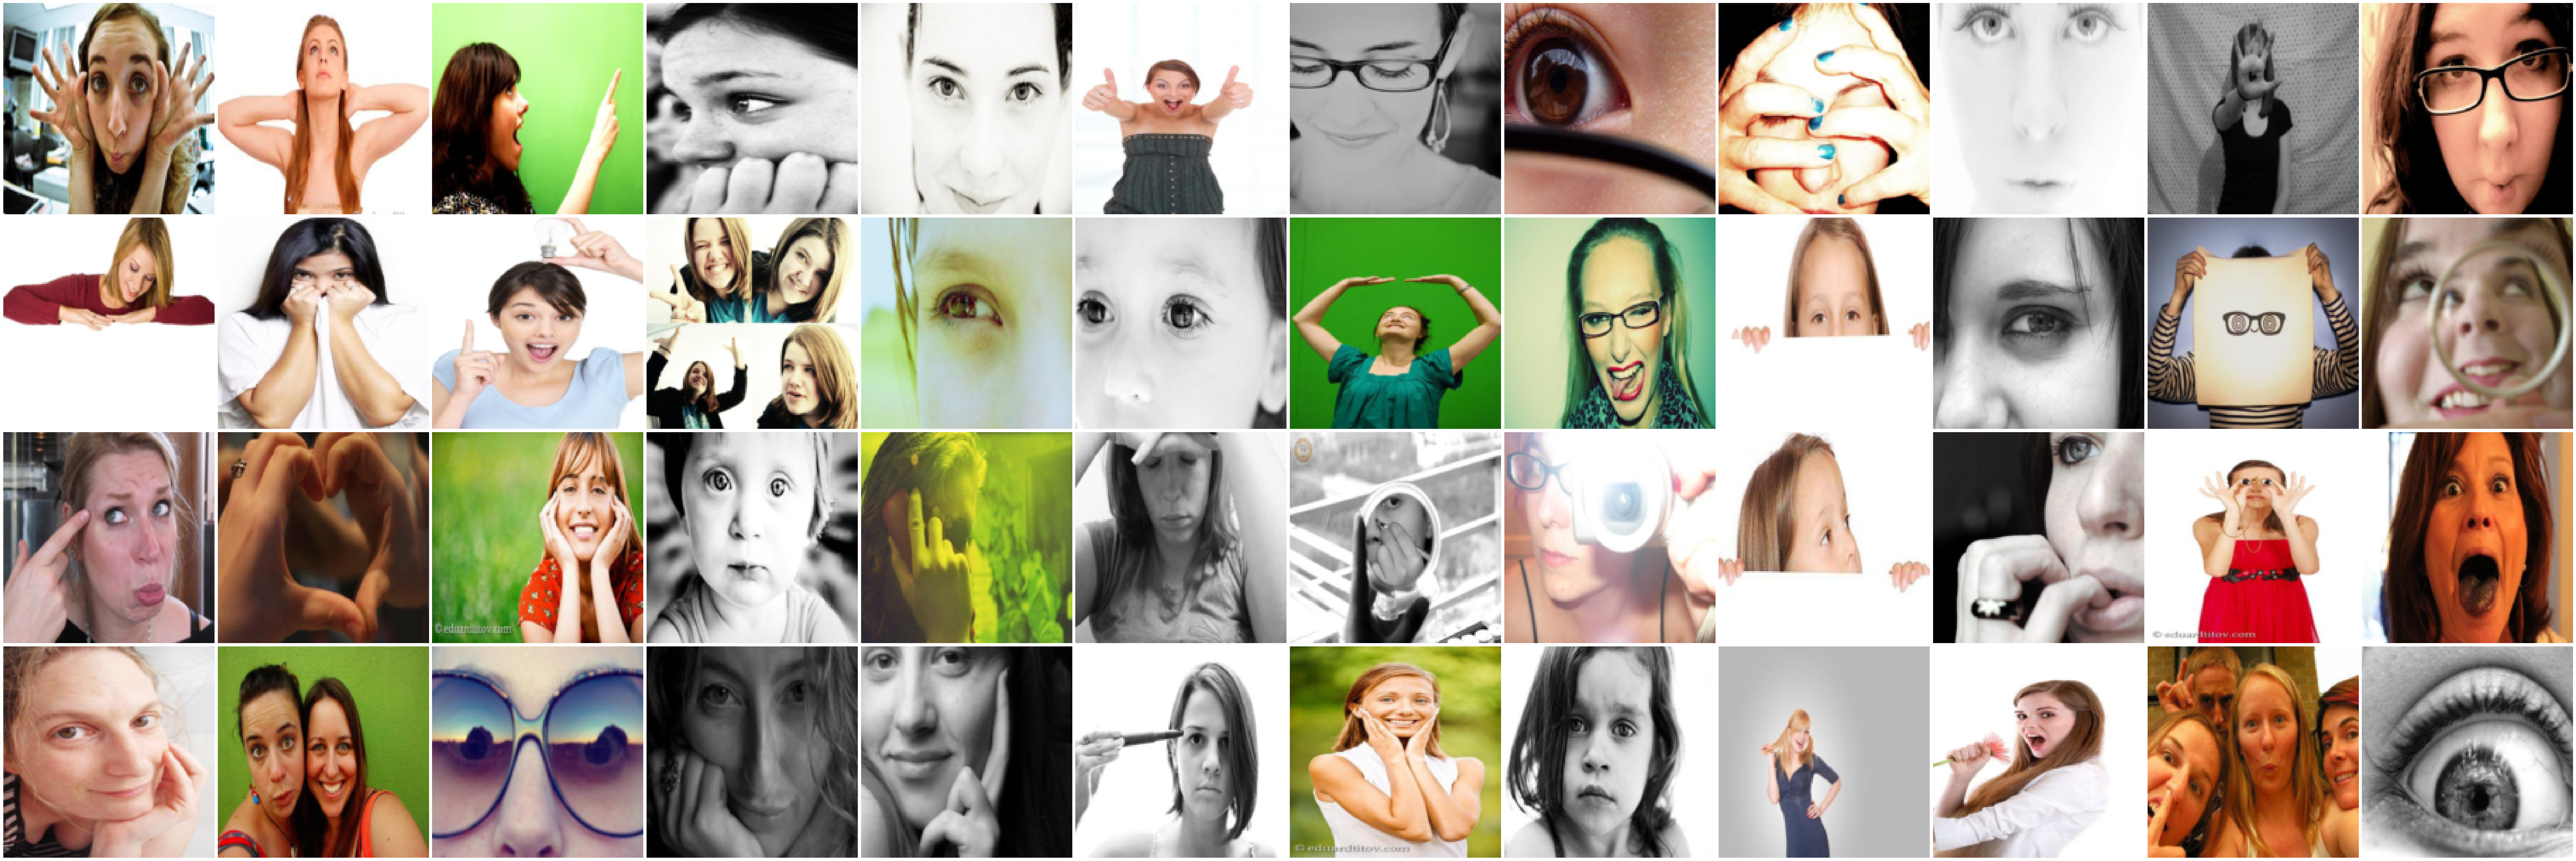

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
res = []
fig = plt.figure(figsize=(100., 100.))
for path in similar:
    img = Image.open(path)
    img = img.resize((150, 150), resample=Image.BILINEAR)
    res.append(img)
    
noRows = 4    
grid = ImageGrid(fig,111,
                 nrows_ncols=(noRows, k//noRows),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, res):
    ax.imshow(im)
    ax.axis('off')

_ = plt.show()